# Decision Trees
<span style="font-size: 12px;">By: Marisol Hernandez</span>

In [59]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

## 1. Introduction to Decision Trees
A **decision tree** is a model widely used in Machine Learning to solve both <u>regression</u> and <u>classification</u> problems. It is a graphical model that mimics human decision making, i.e. it is based on a series of questions to reach a conclusion.

The main idea behind decision trees is to divide data into smaller and smaller groups (called nodes) based on different criteria until a final result or decision is reached. These criteria are selected in such a way that the elements of each node are as similar as possible to each other.

### Structure
The structure of a decision tree resembles that of an inverted tree. It starts with a node called **root node** that contains all the data. This node is split into two or more child nodes based on some criterion. These are the **decision nodes**. This process is repeated for each child node, creating what are called **branches**, until a node is reached that is no longer split. These final nodes are called **leaf nodes** and represent the final decision or prediction of the tree.

<p align="center">
  <img src="imgs/decision_trees1.png" alt="Alt text" width="600" height="350">
</p>

An important aspect of decision trees is that they are very interpretable models. You can visualize the entire tree and follow the decisions it makes, which is not possible in many other types of models. However, they can be prone to overfitting, especially if the tree is allowed to grow too large.

### Example (Classification)
Let’s understand decision trees with the help of an example. Say we want to build a decision tree to determine whether we should play soccer or not.

In [118]:
data_dict = {
    "Weather": ["Sunny", "Cloudy", "Sunny", "Cloudy", "Rainy", "Rainy", "Rainy", "Sunny", "Cloudy", "Rainy"],
    "Humidity": ["High", "High", "Normal", "High", "High", "Normal", "High", "High", "Normal", "High"],
    "Wind": ["Weak", "Weak", "Strong", "Strong", "Strong", "Strong", "Weak", "Strong", "Weak", "Strong"],
    "Play": ["No", "Yes", "Yes", "Yes", "No", "No", "Yes", "No", "Yes", "No"],
}

df = pd.DataFrame(data=data_dict)
df

,Weather,Humidity,Wind,Play
0,Sunny,High,Weak,No
1,Cloudy,High,Weak,Yes
2,Sunny,Normal,Strong,Yes
3,Cloudy,High,Strong,Yes
4,Rainy,High,Strong,No
5,Rainy,Normal,Strong,No
6,Rainy,High,Weak,Yes
7,Sunny,High,Strong,No
8,Cloudy,Normal,Weak,Yes
9,Rainy,High,Strong,No


Decision trees are upside down which means the root is at the top and then this root is split into various several nodes. Decision trees are nothing but a bunch of if-else statements in layman terms. It checks if the condition is true and if it is then it goes to the next node attached to that decision.

In the below diagram the tree will first ask what is the weather? Is it sunny, cloudy, or rainy? If yes then it will go to the next feature which is humidity and wind. It will again check if there is a strong wind or weak, if it’s a weak wind and it’s rainy then the person may go and play.

<p align="center">
  <img src="imgs/decision_trees2.png" alt="Alt text" width="650" height="350">
</p>

Did you notice anything in the above flowchart? We see that if the weather is cloudy then we must go to play. Why didn’t it split more? Why did it stop there?

To answer this question, we need to know about few more concepts like entropy, information gain, and Gini index. But in simple terms, I can say here that the output for the training dataset is always yes for cloudy weather, since there is no disorderliness here we don’t need to split the node further.

In [120]:
# The output is always "Yes" for "Cloudy" data points
df[df["Weather"] == "Cloudy"]

,Weather,Humidity,Wind,Play
1,Cloudy,High,Weak,Yes
3,Cloudy,High,Strong,Yes
8,Cloudy,Normal,Weak,Yes


The goal of machine learning is to decrease uncertainty or disorders from the dataset and for this, we use decision trees.

Now you must be thinking how do I know what should be the root node? what should be the decision node? When should I stop splitting? To decide this, there is a metric called “Entropy” which is the amount of uncertainty in the dataset.

#### `scikit-learn`'s Implementation
Lets fit a decision tree to a our dataset using `scikit-learn`. 

`scikit-learn`'s implementation requires numerical values, so categorical features need to be preprocessed into a numerical format using either factorization, one-hot-encoding, or another encoding method. To meet this requirement, lets set up a pipline to transform out categorical features to numeric using a factorization. For this, we create a custom transformer class and set up a pipeline.

Note: The target variable `Play` does not need to be encoded.

In [121]:
from sklearn.preprocessing import LabelEncoder

# Define the columns to be encoded and not encoded
categorical_cols = ['Weather', 'Humidity', 'Wind']
non_categorical_cols = list(set(df.columns) - set(categorical_cols) - {'Play'})

# Custom Transformer for Label Encoding
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders = {}

    def fit(self, X, y=None):
        for column in X.columns:
            self.encoders[column] = LabelEncoder()
            self.encoders[column].fit(X[column])
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.columns:
            X_copy[column] = self.encoders[column].transform(X_copy[column])
        return X_copy

# Define preprocessing steps for the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('labelencoding', CustomLabelEncoder(), categorical_cols)
    ])

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier()

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

Now split our features and target variable.

In [122]:
# Split features and target variable
X = df.drop(columns=['Play'])
y = df['Play']

In [123]:
X

,Weather,Humidity,Wind
0,Sunny,High,Weak
1,Cloudy,High,Weak
2,Sunny,Normal,Strong
3,Cloudy,High,Strong
4,Rainy,High,Strong
5,Rainy,Normal,Strong
6,Rainy,High,Weak
7,Sunny,High,Strong
8,Cloudy,Normal,Weak
9,Rainy,High,Strong


In [124]:
y

0     No
1    Yes
2    Yes
3    Yes
4     No
5     No
6    Yes
7     No
8    Yes
9     No
Name: Play, dtype: object

Fit the pipeline.

In [125]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('labelencoding',
                                                  CustomLabelEncoder(),
                                                  ['Weather', 'Humidity',
                                                   'Wind'])])),
                ('classifier', DecisionTreeClassifier())])

We can also see how the `CustomLabelEncoder` transformed our categorical features.

In [126]:
# Transform X using the pipeline
X_transformed = pipeline.named_steps['preprocessor'].transform(X)

# Combine transformed features with the target variable
df_transformed = pd.DataFrame(X_transformed, columns=categorical_cols + non_categorical_cols)
df_transformed['Play'] = y

df_transformed

,Weather,Humidity,Wind,Play
0,2,0,1,No
1,0,0,1,Yes
2,2,1,0,Yes
3,0,0,0,Yes
4,1,0,0,No
5,1,1,0,No
6,1,0,1,Yes
7,2,0,0,No
8,0,1,1,Yes
9,1,0,0,No


In [127]:
df_transformed[df_transformed["Weather"] <= 0.5]

,Weather,Humidity,Wind,Play
1,0,0,1,Yes
3,0,0,0,Yes
8,0,1,1,Yes


We can also visualize our decision tree.

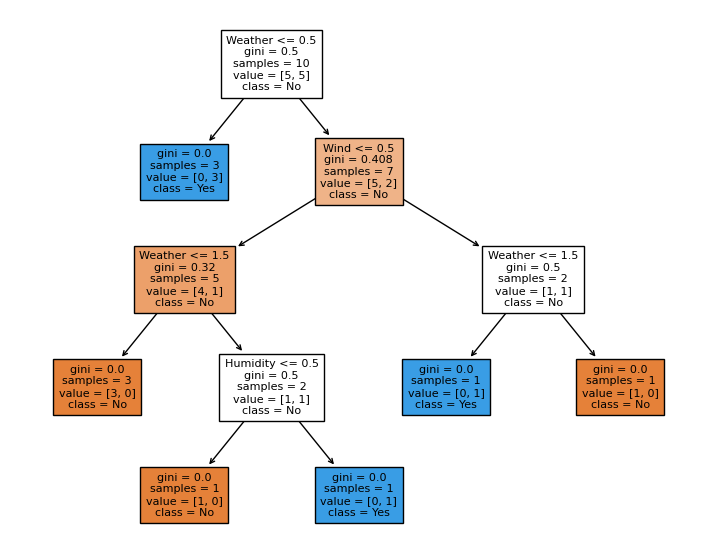

In [112]:
# Visualize the decision tree
plt.figure(figsize=(9, 7))
plot_tree(pipeline['classifier'], feature_names=X.columns, class_names=pipeline['classifier'].classes_, filled=True, fontsize=8)
plt.show()

#### Making Predictions

In [113]:
# Define the new data point
new_data_dict = {
    "Weather": ["Sunny"],
    "Humidity": ["High"],
    "Wind": ["Weak"],
}

# Create a DataFrame for the new data point
new_df = pd.DataFrame(data=new_data_dict)
new_df

,Weather,Humidity,Wind
0,Sunny,High,Weak


In [116]:
# # Transform the new data point using the preprocessor
# new_data_transformed = pipeline.named_steps['preprocessor'].transform(new_df)

# # Combine transformed features into a DataFrame
# new_data_transformed_df = pd.DataFrame(new_data_transformed, columns=categorical_cols)

# print("Transformed new data point:")
# print(new_data_transformed_df)

In [106]:
# Use the pipeline to make predictions
prediction = pipeline.predict(new_df)
print("Prediction:", prediction[0])

Prediction: Yes


## 2. How decision tree algorithms work?
Decision Tree algorithm works in a series of steps:

1. **Starting at the Root**: The algorithm begins at the top, called the “root node,” representing the entire dataset.

2. **Asking the Best Questions**: It looks for the most important feature or question that splits the data into the most distinct groups. This is like asking a question at a fork in the tree.

3. **Branching Out**: Based on the answer to that question, it divides the data into smaller subsets, creating new branches. Each branch represents a possible route through the tree.

4. **Repeating the Process**: The algorithm continues asking questions and splitting the data at each branch until it reaches the final “leaf nodes,” representing the predicted outcomes or classifications.

## 3. Decision Tree Assumptions
Several assumptions are made to build effective models when creating decision trees. These assumptions help guide the tree’s construction and impact its performance. Here are some common assumptions and considerations when creating decision trees:

### Binary Splits
Decision trees typically make binary splits, meaning each node divides the data into two subsets based on a single feature or condition. This assumes that each decision can be represented as a binary choice.

### Recursive Partitioning
Decision trees use a recursive partitioning process, where each node is divided into child nodes, and this process continues until a stopping criterion is met. This assumes that data can be effectively subdivided into smaller, more manageable subsets.

### Feature Independence
Decision trees often assume that the features used for splitting nodes are independent. In practice, feature independence may not hold, but decision trees can still perform well if features are correlated.

### Homogeneity
Decision trees aim to create homogeneous subgroups in each node, meaning that the samples within a node are as similar as possible regarding the target variable. This assumption helps in achieving clear decision boundaries.

### Top-Down Greedy Approach
Decision trees are constructed using a top-down, greedy approach, where each split is chosen to maximize information gain or minimize impurity at the current node. This may not always result in the globally optimal tree.

### Categorical and Numerical Features
Decision trees can handle both categorical and numerical features. `scikit-learn`'s implementation requires numerical values, so categorical features need to be preprocessed into a numerical format using either factorization, one-hot-encoding, or another encoding method. Categorical and numeric features may also require different splitting strategies for each type.

### Overfitting
Decision trees are prone to overfitting when they capture noise in the data. Pruning and setting appropriate stopping criteria are used to address this assumption.

### Impurity Measures
Decision trees use impurity measures such as Gini impurity or entropy to evaluate how well a split separates classes. The choice of impurity measure can impact tree construction.

### No Missing Values
Decision trees assume that there are no missing values in the dataset or that missing values have been appropriately handled through imputation or other methods.

### Equal Importance of Features
Decision trees may assume equal importance for all features unless feature scaling or weighting is applied to emphasize certain features.

### No Outliers
Decision trees are sensitive to outliers, and extreme values can influence their construction. Preprocessing or robust methods may be needed to handle outliers effectively.

### Sensitivity to Sample Size
Small datasets may lead to overfitting, and large datasets may result in overly complex trees. The sample size and tree depth should be balanced.

